In [2]:
'''Retrieve all inputs executed in the current kernel section'''
%history

# Create a count plot for the 'StockCode' column in the df_sales_data DataFrame
sns.countplot(x='StockCode',
              data=df_sales_data,
              order=df_sales_data['StockCode'].value_counts().iloc[:10].index,
              hue='StockCode')
plt.xticks(rotation=45)
'''Retrieve all inputs executed in the current kernel section'''
%history


In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import warnings

In [4]:
print('Pandas version -> %s' % pd.__version__)
print('Numpy version -> %s' % np.__version__)
print('Seaborn version -> %s' % sns.__version__)

Pandas version -> 2.1.2
Numpy version -> 1.26.1
Seaborn version -> 0.13.0


In [5]:
df_sales_data = pd.read_csv('sales_data_cleaned.csv', 
                             index_col='Unnamed: 0',
                             dtype={'InvoiceDate': 'string',
                                    'InvoiceMonth': 'category',
                                    'DayPart': 'category',
                                    'InvoiceNo': 'category',
                                    'CustomerID': 'string',
                                    'Country': 'category',
                                    'StockCode': 'category',
                                    'Quantity': 'int64',
                                    'UnitPrice': 'float64',
                                    'Revenue': 'float64'},
                             parse_dates=['InvoiceDate'])

In [6]:
df_sales_data.head()

,InvoiceDate,InvoiceMonth,DayPart,InvoiceNo,CustomerID,Country,StockCode,Quantity,UnitPrice,Revenue
0,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,85123A,6,2.55,15.30
1,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,71053,6,3.39,20.34
2,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,84406B,8,2.75,22.00
3,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,84029G,6,3.39,20.34
4,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,84029E,6,3.39,20.34


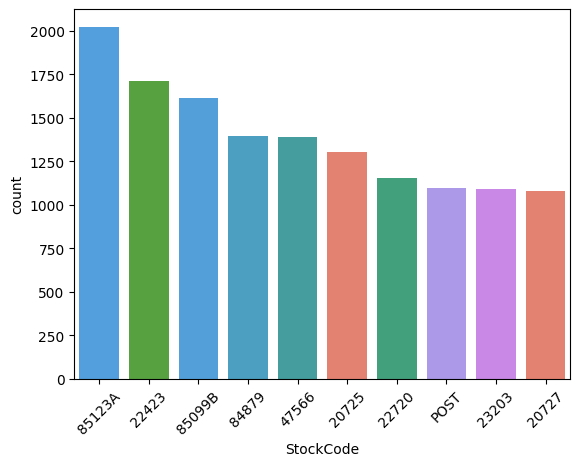

In [8]:
# Create a count plot for the 'StockCode' column in the df_sales_data DataFrame
sns.countplot(x='StockCode',
              data=df_sales_data,
              order=df_sales_data['StockCode'].value_counts().iloc[:10].index,
              hue='StockCode')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Group the sales data by 'InvoiceNo'
df_products_per_invoice = df_sales_data.groupby(['InvoiceNo'],observed=False)[['StockCode']].count()
df_quantity_per_invoice = df_sales_data.groupby(['InvoiceNo'],observed=False)[['Quantity']].sum()

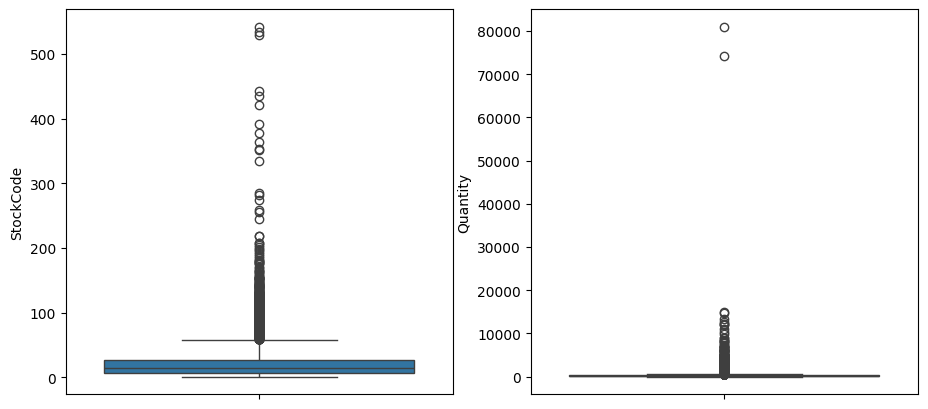

In [15]:
# Plot StockCode count and Quantity distributions
fig, ax = plt.subplots(nrows=1, ncols=2,
                      figsize=(11,5))


sns.boxplot(y='StockCode',data=df_products_per_invoice,ax=ax[0])
sns.boxplot(y='Quantity',data=df_quantity_per_invoice,ax=ax[1])

plt.show()

In [16]:
#Filter outliers products
Q1 = df_products_per_invoice.quantile(0.25)
Q3 = df_products_per_invoice.quantile(0.75)
IQR = Q3 - Q1

df_products_per_invoice = df_products_per_invoice[~(df_products_per_invoice > (Q3 + 1.5*IQR)).any(axis=1)]

#Filter outliers quantity
Q1 = df_quantity_per_invoice.quantile(0.25)
Q3 = df_quantity_per_invoice.quantile(0.75)
IQR = Q3 - Q1

df_quantity_per_invoice = df_quantity_per_invoice[~(df_quantity_per_invoice > (Q3 + 1.5*IQR)).any(axis=1)]

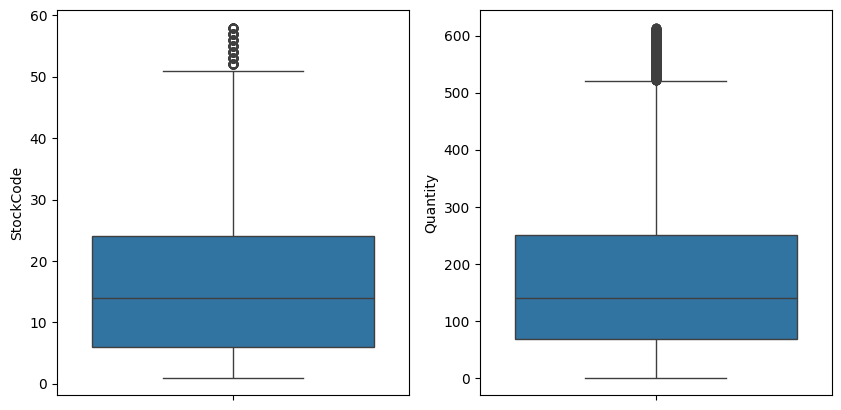

In [18]:
# Plot StockCode count and Quantity new distributions

fig, ax = plt.subplots(nrows=1, ncols=2,
                      figsize=(10,5))

sns.boxplot(y='StockCode',data=df_products_per_invoice,ax=ax[0])

sns.boxplot(y='Quantity',data=df_quantity_per_invoice,ax=ax[1])

plt.show()

In [21]:
#Filter df_sales_data
df_products_per_invoice.reset_index(inplace=True)
df_quantity_per_invoice.reset_index(inplace=True)

df_sales_data = df_sales_data[df_sales_data['InvoiceNo'].isin(df_products_per_invoice['InvoiceNo'])]
df_sales_data = df_sales_data[df_sales_data['InvoiceNo'].isin(df_quantity_per_invoice['InvoiceNo'])]

In [22]:
df_sales_data['InvoiceNo'].nunique()

16392

In [23]:
# Create a basket DataFrame using a crosstabulation of 'InvoiceNo' and 'StockCode'
df_basket = pd.crosstab(df_sales_data['InvoiceNo'], df_sales_data['StockCode'])

In [24]:
# Define a function to encode item frequency as True (if > 0) or False (if 0)
def encode(item_freq):
    res = False
    if item_freq > 0:
        res = True
    return res
    
df_basket = df_basket.map(encode)
df_basket.shape

(16392, 3583)

In [26]:
# Import the necessary functions from the mlxtend library
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Find frequent itemsets using the Apriori algorithm with a minimum support of 0.005
frequent_itemsets = apriori(df_basket, min_support=0.005, use_colnames=True)

# Generate association rules from the frequent itemsets using the lift metric
rules = association_rules(frequent_itemsets, metric="lift")

In [27]:
# Sort the association rules by 'support', 'confidence', and 'lift' in descending order
top_rules = rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False).head(5)
top_rules.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1206,(22726),(22727),0.037701,0.041423,0.024890,0.660194,15.938001,0.023329,2.820956,0.973977
1207,(22727),(22726),0.041423,0.037701,0.024890,0.600884,15.938001,0.023329,2.411073,0.977758
1136,(22697),(22699),0.032516,0.036664,0.024829,0.763602,20.826902,0.023637,4.075063,0.983980
1137,(22699),(22697),0.036664,0.032516,0.024829,0.677205,20.826902,0.023637,2.997206,0.988217
899,(22386),(85099B),0.040752,0.074427,0.023914,0.586826,7.884637,0.020881,2.240156,0.910266


In [28]:
# Format the StockCodes for better readability and further analysis
rules["antecedents"] = rules["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
rules["consequents"] = rules["consequents"].apply(lambda x: list(x)[0]).astype("unicode")

In [30]:
# Group the sales data by 'StockCode' and sum the quantities for each stock code
df_quantity_per_stockcode = df_sales_data.groupby(['StockCode'],observed=False,as_index=False)[['Quantity']].sum()

# Create a new column 'Cut' based on quantiles of 'Quantity'
# 'Cut' will contain the bin number for each stock code
df_quantity_per_stockcode['Cut'] = pd.qcut(df_quantity_per_stockcode['Quantity'],10,labels=False,duplicates='drop')

# Create a new column 'Bins' based on quantiles of 'Quantity'
# 'Bins' will contain the range labels for each bin
df_quantity_per_stockcode['Bins'] = pd.qcut(df_quantity_per_stockcode['Quantity'],10,labels=None,duplicates='drop')

# Group the DataFrame by both 'Cut' and 'Bins' and calculate the count of stock codes and the mean quantity for each combination
df_quantity_per_stockcode.groupby(['Cut','Bins'],observed=True).agg( StockCode=('StockCode', "count"),
                                                                     Quantity=('Quantity', "mean"))

,,StockCode,Quantity
Cut,Bins,,
0,"(-0.001, 6.0]",399,2.458647
1,"(6.0, 23.0]",337,13.771513
2,"(23.0, 59.0]",366,38.603825
3,"(59.0, 122.2]",364,88.269231
4,"(122.2, 218.0]",367,167.591281
5,"(218.0, 373.4]",365,291.663014
6,"(373.4, 616.1]",367,485.043597
7,"(616.1, 1041.4]",366,795.800546
8,"(1041.4, 1918.9]",366,1411.997268


In [23]:
# Find unique stock codes with 'Cut' value equal to 7 (indicating low sales)
low_sales_items = np.unique(df_quantity_per_stockcode[df_quantity_per_stockcode['Cut']==7].StockCode)

# Filter association rules to include only those with consequents in low sales items
df_low_sales_items = rules[rules.consequents.isin(low_sales_items)]

print('Items: ', df_quantity_per_stockcode.StockCode.nunique())
print('Itenm with low sales: ', len(df_low_sales_items))
print('Rules rows: ', len(rules))
print('Rules rows with low sales items: ', len(df_low_sales_items))

Items:  3664
Itenm with low sales:  77
Rules rows:  3382
Rules rows with low sales items:  77


In [24]:
# Print the association rules with consequents in low sales items
df_low_sales_items

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
241,20749,20750,0.017069,0.016050,0.005605,0.328358,20.458541,0.005331,1.464992,0.967637
244,20970,20969,0.009490,0.009936,0.005605,0.590604,59.442781,0.005510,2.418354,0.992597
245,20969,20970,0.009936,0.009490,0.005605,0.564103,59.442781,0.005510,2.272347,0.993044
342,21535,21533,0.013375,0.014267,0.005541,0.414286,29.038839,0.005350,1.682959,0.978653
344,21559,21558,0.015477,0.009044,0.005032,0.325103,35.946763,0.004892,1.468307,0.987464
...,...,...,...,...,...,...,...,...,...,...
3305,22919,22921,0.005923,0.005668,0.005159,0.870968,153.652410,0.005125,7.706070,0.999412
3326,22918,22921,0.005605,0.006178,0.005032,0.897727,145.311504,0.004997,9.717371,0.998716
3334,22918,22921,0.005923,0.005668,0.005032,0.849462,149.858524,0.004998,6.605203,0.999246
3356,22918,22921,0.005668,0.006178,0.005032,0.887640,143.678791,0.004997,8.845016,0.998701


Now that we've identified the items paired with low-sales items, we can strategize marketing campaigns targeting these pairs. This approach aims to boost sales of low-performing items by promoting their frequently associated items.